In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
def phi_in_gaussian(kx, ky, F4, l):
    k = np.sqrt(kx * kx + ky * ky)
    return k * np.exp(-k*k / F4) / ((kx + l*1.0j) * (kx + l*1.0j) - k)

def calculate_wake(F, l=0.002, kmax=64, d=0.03125):
    k = np.arange(-kmax, kmax+d, d)
    n = len(k)
    
    m = (n - 1) / 2
    x = pi / (d * m) * np.arange(-m, m+1, 1)
    
    phi_induced = phi_in_gaussian(k[:, None], k[None, :], \
                                  np.power(F, 4.0), l)
    
    #Rotate grid since dft starts at zero
    phi_grid = np.roll(phi_induced, -m, axis=0)
    phi_grid = np.roll(phi_grid, -m, axis=1)
    
    fPhi = d*d * np.fft.ifft2(phi_grid)
    fPhi = np.roll(fPhi, m, axis=1)
    fPhi = np.roll(fPhi, m, axis=0)
    fPhi = np.transpose(fPhi)
    
    return x, fPhi

In [21]:
phase = -1.7

def draw_wake_plot(ax, x, phi, bound=None, scale=False):
    r = x[-1]
    stdev = np.std(phi)
    if bound is not None:
        avg = np.average(phi)
        ubound = avg + bound * stdev
        lbound = avg - bound * stdev
        toshow = phi * (phi < ubound) * (phi > lbound)
        toshow[phi > ubound] = ubound
        toshow[phi < lbound] = lbound
    else:
        toshow = phi
    if scale:
        toshow -= avg
        toshow = toshow / (ubound - lbound) * 2
        img = plt.imshow(toshow, extent=[-r, r, -r, r], \
                         interpolation='gaussian',
                         vmin=-1, vmax=1)
    else:
        ubound = np.max(toshow[:])
        lbound = np.min(toshow[:])
        rnge = ubound - lbound
        toshow = toshow - lbound - rnge/2
        toshow = toshow / rnge * 2
        img = plt.imshow(toshow, extent=[-r, r, -r, r], \
                         interpolation='gaussian')
    return img

def draw_kelvin_angle(ax, x, f=1000, color='blue'):
    y = np.sqrt(x**2.0/8.)
    ax.plot(x, y, color=color, linestyle=':')

def draw_inner_angle(ax, x, T, color='black'):
    slope = np.sqrt(T - 1.) / (2. * T - 1.)
    y = slope * x
    ax.plot(x, -y, color=color, linestyle=':')
    
def draw_parametric_wake(ax, nmax, t, color='black', phase=phase):
    t32 = np.power(t, 1.5)
    xtterm = (2*t - 1) / t32
    ytterm = np.sqrt(t - 1) / t32
    for n in range(1, nmax+1):
        t32 = np.power(t, 1.5)
        xt = -np.pi * (2 * n + 1 + phase) * xtterm
        yt = -np.pi * (2 * n + 1 + phase) * ytterm
        ax.plot(xt, -yt, color=color, linestyle=':', linewidth=1)

def draw_slope_xint(ax, slope, xint, x0, color='black', full=False):
    x = np.array([x0, xint])
    y = slope * (x - xint)
    ax.plot(x, y, color=color, linestyle=':', linewidth=1)
    if full:
        ax.plot(x, -y, color=color, linestyle=':', linewidth=1)
        
def format_single_plot(fig, img, title, xlim, ylim):
    ax = fig.gca()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    fig.suptitle(title)
    fig.colorbar(img)
    
def calc_a_value(slope, f):
    m2 = slope * slope
    T = 1. / (8. * m2) * (1 + 4 * m2 + np.sqrt(1 - 8 * m2))
    return T / (f * f)

a = np.average([calc_a_value(0.05, np.sqrt(128)),
                calc_a_value(0.0459, np.sqrt(128)),
                calc_a_value(0.0328, 16),
                calc_a_value(0.0353, 16)])

def calc_T_value(f, a=a):
    return a * f * f

def slope_xint(r1, r2, refpx, refpt, dimp, dimx):
    ratx = dimx[0] / dimp[0]
    raty = dimx[1] / dimp[1]
    x1 = (r1[0] - refpx[0]) * ratx + refpt[0]
    y1 = (r1[1] - refpx[1]) * raty + refpt[1]
    x2 = (r2[0] - refpx[0]) * ratx + refpt[0]
    y2 = (r2[1] - refpx[1]) * raty + refpt[1]
    m = (y2 - y1) / (x2 - x1)
    xint = -y1 / m + x1
    return m, xint

In [4]:
def create_large_figure(fig, xvals, phis, froudes, nrows, ncols, bound=None, scale=False,
                        kelvin=False, inner=False, parametric=False, xshift=0, xfull=False,
                        xbounds=None, ybounds=None, slopes=None, xints=None, cbar=False):
    if xbounds is None and ybounds is None:
        try:
            xbounds = [xvals[0, 0], xvals[0, -1] if xfull else 0]
            ybounds = [xvals[0, 0]/2, xvals[0, -1]/2]
        except:
            xbounds = [xvals[0][0], xvals[0][-1] if xfull else 0]
            ybounds = [xvals[0][0]/2, xvals[0][-1]/2]
        xbounds = xbounds - xbounds[0] * xshift
    label = 'a'
    
    for r in range(nrows):
        for c in range(ncols):
            i = r * ncols + c
            ax = fig.add_subplot(nrows, ncols, i+1)
            ax.set_xlim(xbounds)
            ax.set_ylim(ybounds)
            ax.text(0.97, 0.97, 'F=%f' % froudes[i], 
                    transform=ax.transAxes,
                    horizontalalignment='right',
                    verticalalignment='top')
            ax.text(0.97, 0.03, label, 
                    transform=ax.transAxes,
                    horizontalalignment='right',
                    verticalalignment='bottom')
            label = chr(ord(label) + 1)
            img = draw_wake_plot(ax, xvals[i], phis[i], bound=bound, scale=scale)

            if slopes is not None and xints is not None:
                draw_slope_xint(ax, slopes[i], xints[i], xbounds[0], full=True)
                if kelvin:
                    draw_slope_xint(ax, -1./np.sqrt(8), xints[i], xbounds[0])
            else:
                xs = xvals[i][xvals[i] <= 0]
                if kelvin:                    
                    draw_kelvin_angle(ax, xs)
                if inner:
                    draw_inner_angle(ax, xs, froudes[i]**2.)
                if parametric:
                    t = np.linspace(1, froudes[i]**2., 10000)
                    draw_parametric_wake(ax, 4, t, color='black')
            if c == 0:
                ax.set_ylabel('Y')
            else:
                nlbls = len(ax.get_yticklabels())
                ax.set_yticklabels([''] * nlbls)
            if r == nrows - 1:
                ax.set_xlabel('X')
            else:
                nlbls = len(ax.get_xticklabels())
                ax.set_xticklabels([''] * nlbls)

In [5]:
#froudes = np.arange(16) * 0.5 + 0.5 #Look at F from 0.5 to 5.0
#froudes = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0]
froudes = np.array([0.6, 0.7, 0.8, 0.9, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0])
froudes = np.array([0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1.0, 1.02, 1.04, 1.06, 1.08, 1.10, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0])

nfroudes = len(froudes)
print(nfroudes)
kmax = 128
delta = 1.0 / 8
lambd=0.01
arrsize = int(kmax / delta * 2 + 1)

def generate_wake_patterns(fvals, xfile=None, pfile=None):
    phis = np.zeros((nfroudes, arrsize, arrsize))
    xs = np.zeros((nfroudes, arrsize))
    for i, f in enumerate(fvals):
        x, p = calculate_wake(f, kmax=kmax, d=delta, l=lambd)
        xs[i, :] = np.real(x)
        phis[i, :, :] = np.real(p)
        print('F = %f done' % f)
        
    if xfile is not None:
        with open(xfile, 'wb+') as fh:
            np.save(fh, xs, allow_pickle=False)
    if pfile is not None:
        with open(pfile, 'wb+') as fh:
            np.save(fh, phis, allow_pickle=False)
        
    return xs, phis

34


In [6]:
npfilephi = 'gaussian_patterns.npy'
npfilex = 'gaussian_xvals.npy'
useSaves = False
if useSaves:
    try:
        xvals = np.load(npfilex)
        phis = np.load(npfilephi)
        print('Loaded from file')
    except:
        print('Files do not exist. Generating Wake Patterns')
        xvals, phis = generate_wake_patterns(froudes, \
                                             xfile=npfilex, \
                                             pfile=npfilephi)
        print('Saved to files %s and %s' % (npfilephi, npfilex))
else:
    xvals, phis = generate_wake_patterns(froudes)

F = 0.700000 done
F = 0.720000 done
F = 0.740000 done
F = 0.760000 done
F = 0.780000 done
F = 0.800000 done
F = 0.820000 done
F = 0.840000 done
F = 0.860000 done
F = 0.880000 done
F = 0.900000 done
F = 0.920000 done
F = 0.940000 done
F = 0.960000 done
F = 0.980000 done
F = 1.000000 done
F = 1.020000 done
F = 1.040000 done
F = 1.060000 done
F = 1.080000 done
F = 1.100000 done
F = 1.150000 done
F = 1.200000 done
F = 1.250000 done
F = 1.300000 done
F = 1.350000 done
F = 1.400000 done
F = 1.450000 done
F = 1.500000 done
F = 1.600000 done
F = 1.700000 done
F = 1.800000 done
F = 1.900000 done
F = 2.000000 done


In [28]:
dimp = [284, 142]
dimx = [50.26, 25.13]
refpt = [-25.13, 0]

r1s = [[49, 124],
       [414, 120],
       #[49, 286],
       [49, 289],
       [414, 291],
       [49, 468],
       [414, 468],
       [49, 640],
       [414, 640]]
r2s = [[186, 96],
       [550, 94],
       #[192, 260],
       [188, 260],
       [552, 263],
       [186, 432],
       [553, 433],
       [183, 601],
       [540, 605]]
refpxs = [[49, 81],
          [414, 81],
          [49, 252], 
          [414, 252],
          [49, 422],
          [414, 422],
          [49, 592],
          [414, 592]]

slopes = []
xints = []

mask = np.logical_and(froudes >= 0.86, froudes <= 1)
fslps = froudes[mask]

for i in range(len(r1s)):
    m, xint = slope_xint(r1s[i], r2s[i], refpxs[i], refpt, dimp, dimx)
    slopes.append(m)
    xints.append(xint)
    print('F = %.3f\tSlope = %f\t X-Intercept = %f' % (fslps[i], m, xint))

#fig = plt.figure(figsize=(12, 12))
#mask = np.logical_and(froudes >= 0.86, froudes <= 1)
#create_large_figure(fig, xvals[mask], phis[mask], froudes[mask], 4, 2, kelvin=True, 
#                    xfull=True, slopes=slopes, xints=xints)
#plt.show()

F = 0.860	Slope = -0.204380	 X-Intercept = 12.103609
F = 0.880	Slope = -0.191176	 X-Intercept = 10.972254
F = 0.900	Slope = -0.208633	 X-Intercept = 6.255039
F = 0.920	Slope = -0.202899	 X-Intercept = 8.886514
F = 0.940	Slope = -0.262774	 X-Intercept = 5.849902
F = 0.960	Slope = -0.251799	 X-Intercept = 7.200225
F = 0.980	Slope = -0.291045	 X-Intercept = 4.056739
F = 1.000	Slope = -0.277778	 X-Intercept = 5.450732


/home/jcolen19/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt


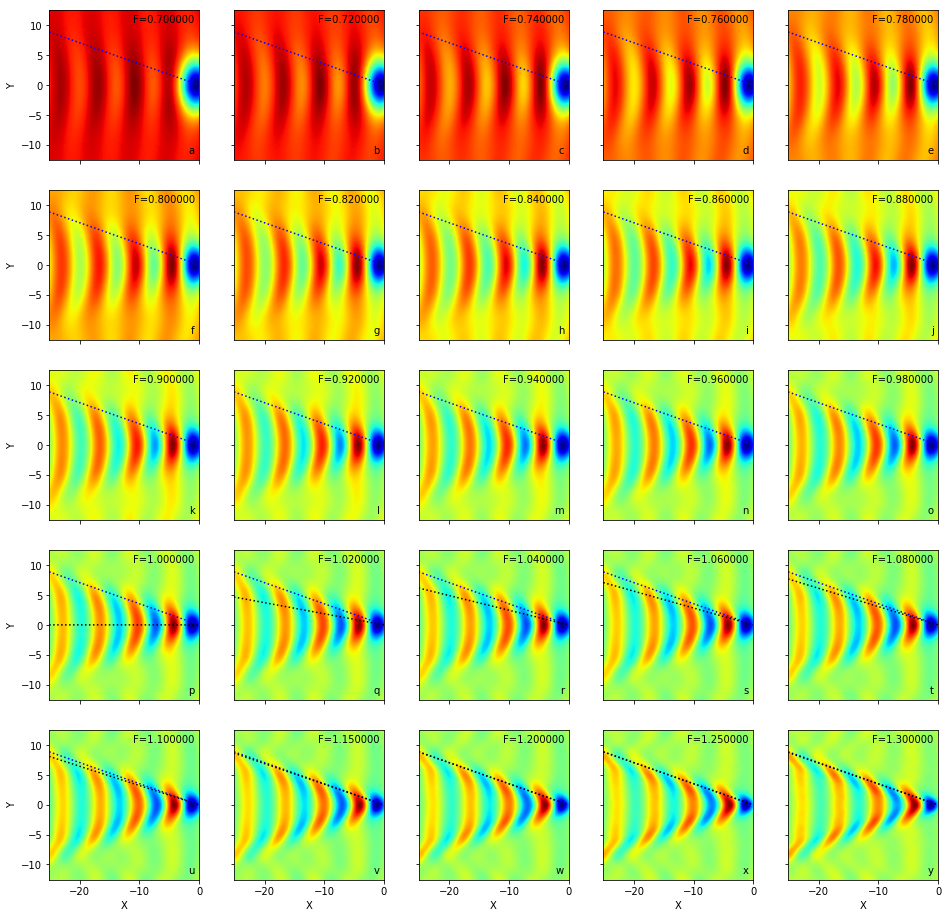

In [12]:
fig = plt.figure(figsize=(16, 16))
create_large_figure(fig, xvals, phis, froudes, 
                    5, 5, kelvin=True, inner=True)
plt.show()

In [29]:
fins = [2.5, 3, 3.5, 4, 5]
kmaxs = [256, 256, 256, 256, 256]
nins = len(fins)
pins = []
xins = []
for f, k in zip(fins, kmaxs):
    x, p = calculate_wake(f, kmax=k, d=delta, l=lambd)
    xins.append(np.real(x))
    pins.append(np.real(p))
    print('F = %f done' % f)

F = 2.500000 done
F = 3.000000 done
F = 3.500000 done
F = 4.000000 done
F = 5.000000 done


F = 0.860, T = 1.035
F = 0.900, T = 1.134
F = 0.940, T = 1.237
F = 0.980, T = 1.345
F = 1.000, T = 1.400
F = 1.200, T = 2.016
F = 1.300, T = 2.366
F = 1.400, T = 2.744
F = 1.500, T = 3.150
F = 1.600, T = 3.584
F = 1.800, T = 4.536
F = 2.000, T = 5.600
F = 2.500, T = 8.750
F = 3.000, T = 12.600
F = 3.500, T = 17.150


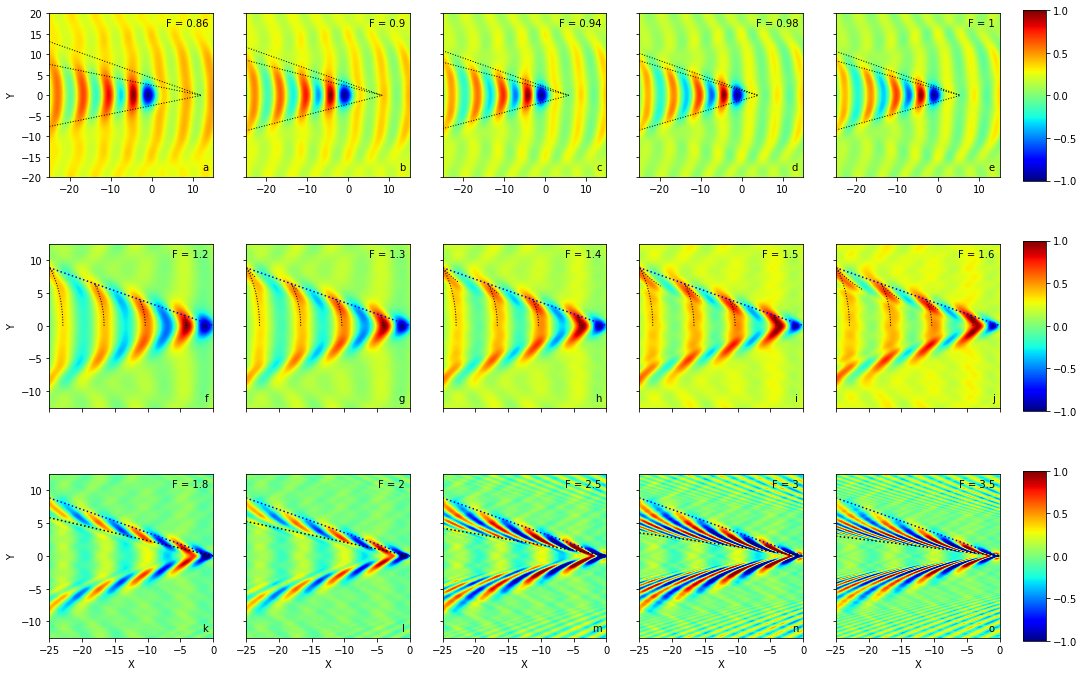

In [31]:
slps = [slopes[0], slopes[2]-0.05, slopes[4], slopes[6], slopes[7]]
xnts = [xints[0], xints[2]+2., xints[4], xints[6], xints[7]]
xbounds0 = [-25, 15]
ybounds0 = [-20, 20]
rows = np.array([[0.86, 0.90, 0.94, 0.98, 1.0],
                 [1.02, 1.06, 1.1, 1.15, 1.2],
                 [1.6, 2, 3, 4, 5]])
row2bs = np.array([2.5, 2, 1.5, 1.0, 0.75])
row2bs = np.array([8, 8, 5, 3, 1.5])
rows = np.array([[0.86, 0.90, 0.94, 0.98, 1.0],
                  [1.2, 1.3, 1.4, 1.5, 1.6],
                  [1.8, 2, 2.5, 3, 3.5]])
row2bs = np.array([8, 8, 5, 4, 4])


xbounds = [-25, 0]
ybounds = [-12.5, 12.5]
npy, npx = rows.shape

a = 1.4

fig = plt.figure(figsize=(16, 12))
axs, imgs = [None, None, None], [None, None, None]
label = 'a'
for j in range(npy):
    for i in range(npx):
        ax = fig.add_subplot(npy, npx, j*npx + i + 1)
        fr = rows[j, i]
        if fr in froudes:
            ind = np.argwhere(froudes==fr)[0][0]
        else:
            ind = fins.index(fr)
        ax.set_xlim(xbounds)
        ax.set_ylim(ybounds)
        ax.text(0.97, 0.97, r'F = %g' % fr, transform=ax.transAxes, 
                    horizontalalignment='right', 
                    verticalalignment='top')
        ax.text(0.97, 0.03, label, transform=ax.transAxes,
                    horizontalalignment='right',
                    verticalalignment='bottom')
        label = chr(ord(label) + 1)
        T = a * fr * fr
        print('F = %.3f, T = %.3f' % (fr, T))
        if j == 0:
            img = draw_wake_plot(ax, xvals[ind], phis[ind], scale=False)
            ax.set_xlim(xbounds0)
            ax.set_ylim(ybounds0)
            draw_slope_xint(ax, slps[i], xnts[i], xbounds0[0], full=True)
            draw_slope_xint(ax, -1./np.sqrt(8), xnts[i], xbounds0[0])
        elif j == 1:
            img = draw_wake_plot(ax, xvals[ind], phis[ind], scale=False)
            t = np.linspace(1, T, 10000)
            draw_parametric_wake(ax, 4, t, color='black')
            draw_kelvin_angle(ax, xvals[ind])
            #Clear tick labels
            nlbls = len(ax.get_xticklabels())
            ax.set_xticklabels([''] * nlbls)
        elif j == 2:
            if fr in froudes:
                img = draw_wake_plot(ax, xvals[ind], phis[ind], bound=row2bs[i], scale=True)
                draw_kelvin_angle(ax, xvals[ind])
                draw_inner_angle(ax, xvals[ind], T, color='black')
            else:
                img = draw_wake_plot(ax, xins[ind], pins[ind], bound=row2bs[i], scale=True)
                draw_kelvin_angle(ax, xins[ind])
                draw_inner_angle(ax, xins[ind], T, color='black')
            ax.set_xlabel('X')

        if i == 0:
            ax.set_ylabel('Y')
        else:
            #Clear tick labels
            nlbls = len(ax.get_yticklabels())
            ax.set_yticklabels([''] * nlbls)
        axs[j] = ax
        imgs[j] = img

#Add colorbars
fig.subplots_adjust(right=0.95)
for j in range(npy):
    bb = axs[j].get_position().bounds
    cbar_ax = fig.add_axes([0.97, bb[1]+0.0125, 0.02, bb[3]-0.025])
    fig.colorbar(imgs[j], cax=cbar_ax, ticks=[-1, -0.5, 0, 0.5, 1.0])

plt.show()
